In [2]:
import numpy as np
import matplotlib.pyplot as plt
import OpenVisus as ov
import cartopy.crs as ccrs
import cartopy.feature as cfeature

try:
    from tqdm.notebook import tqdm
except ImportError:
    from tqdm import tqdm
    print("Using regular tqdm instead of notebook version")
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.dates as mdates

# Set up environment
import os
os.environ['VISUS_CACHE'] = "./visus_can_be_deleted"

In [8]:
def load_temperature_dataset():
    """
    Load the theta (temperature) dataset and return the database object
    """
    variable = 'theta'
    field = f"https://maritime.sealstorage.io/api/v0/s3/utah/nasa/dyamond/mit_output/llc2160_{variable}/llc2160_{variable}.idx?access_key=any&secret_key=any&endpoint_url=https://maritime.sealstorage.io/api/v0/s3&cached=arco"
    
    db = ov.LoadDataset(field)
    print(f'Dimensions: {db.getLogicBox()[1][0]}*{db.getLogicBox()[1][1]}*{db.getLogicBox()[1][2]}')
    print(f'Total Timesteps: {len(db.getTimesteps())}')
    print(f'Field: {db.getField().name}')
    print('Data Type: float32')
    
    return db

In [7]:
def read_temperature_data(db, timestep=0, resolution=-15):
    """
    Read temperature data for a specific timestep
    
    Parameters:
    db (ov.Dataset): OpenVisus dataset object
    timestep (int): Timestep to read
    resolution (int): Resolution level (-15 to 0)
    
    Returns:
    np.ndarray: Temperature data
    """
    data = db.read(time=timestep, quality=resolution)
    print(f"Data shape: {data.shape}")
    print(f"Data min: {np.nanmin(data)}, max: {np.nanmax(data)}")
    
    # If data is 3D (has depth dimension), return the surface layer
    if len(data.shape) == 3:
        return data[0]  # First depth level (surface)
    else:
        return data

In [47]:
def visualize_temperature(data, vmin=0, vmax=33, cmap='turbo', title='Sea Surface Temperature (Theta)', 
                          save_path='temperature_visualization.png'):
    """
    Create and save a visualization of temperature data
    
    Parameters:
    data (np.ndarray): Temperature data array
    vmin (float): Minimum value for colormap
    vmax (float): Maximum value for colormap
    cmap (str): Matplotlib colormap name
    title (str): Plot title
    save_path (str): Path to save the visualization
    """
    plt.figure(figsize=(12, 8))
    
    # Create the plot with temperature colormap
    im = plt.imshow(data, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
    
    # Add colorbar
    cbar = plt.colorbar(im, label='Temperature (°C)')
    
    # Add title
    plt.title(title)
    
    # Save the figure
    plt.savefig(save_path, dpi=150)
    plt.close()
    print(f"Visualization saved as '{save_path}'")

previous

In [48]:
def visualize_indian_ocean_region(data, y_slice=(0.45, 0.71), x_slice=(0.2, 0.6), 
                                 vmin=0, vmax=33, cmap='turbo', 
                                 title='Indian Ocean Region Sea Surface Temperature',
                                 save_path='indian_ocean_temperature.png'):
    """
    Create and save a visualization focused on the Indian Ocean region
    
    Parameters:
    data (np.ndarray): Full temperature data array
    y_slice (tuple): Relative start and end points for y-axis (0-1)
    x_slice (tuple): Relative start and end points for x-axis (0-1)
    vmin (float): Minimum value for colormap
    vmax (float): Maximum value for colormap
    cmap (str): Matplotlib colormap name
    title (str): Plot title
    save_path (str): Path to save the visualization
    """
    # Calculate region boundaries
    y_start = int(data.shape[0] * y_slice[0])
    y_end = int(data.shape[0] * y_slice[1])
    x_start = int(data.shape[1] * x_slice[0])
    x_end = int(data.shape[1] * x_slice[1])
    
    # Extract the region of interest
    region_data = data[y_start:y_end, x_start:x_end]
    
    # Create the visualization
    plt.figure(figsize=(12, 8))
    
    # Create the plot with temperature colormap
    im = plt.imshow(region_data, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
    
    # Add colorbar
    cbar = plt.colorbar(im, label='Temperature (°C)')
    
    # Add title
    plt.title(title)
    
    # Save the figure
    plt.savefig(save_path, dpi=150)
    plt.close()
    print(f"Focused visualization saved as '{save_path}'")

new

In [21]:
def visualize_indian_ocean_region(data, y_slice=(0.45, 0.71), x_slice=(0.2, 0.6), 
                                 vmin=0, vmax=33, cmap='turbo', 
                                 title='Indian Ocean Region Sea Surface Temperature',
                                 save_path='indian_ocean_temperature.png'):
    """
    Create and save a visualization focused on the Indian Ocean region with fixed lon/lat range
    
    Parameters:
    data (np.ndarray): Full temperature data array
    y_slice (tuple): Relative start and end points for y-axis (0-1)
    x_slice (tuple): Relative start and end points for x-axis (0-1)
    vmin (float): Minimum value for colormap
    vmax (float): Maximum value for colormap
    cmap (str): Matplotlib colormap name
    title (str): Plot title
    save_path (str): Path to save the visualization
    """
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate region boundaries
    y_start = int(data.shape[0] * y_slice[0])
    y_end = int(data.shape[0] * y_slice[1])
    x_start = int(data.shape[1] * x_slice[0])
    x_end = int(data.shape[1] * x_slice[1])
    
    # Extract the region of interest
    region_data = data[y_start:y_end, x_start:x_end]
    
    # Create the visualization
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Create the plot with temperature colormap
    im = ax.imshow(region_data, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax, 
                   extent=[37, 175, -37, 37])  # Force exact coordinate range
    
    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Set x ticks (longitude) - create evenly spaced ticks
    lon_ticks = np.linspace(37, 175, 10)
    ax.set_xticks(lon_ticks)
    ax.set_xticklabels([f'{int(lon)}°E' for lon in lon_ticks])
    
    # Set y ticks (latitude) - create evenly spaced ticks
    lat_ticks = np.linspace(-37, 37, 10)
    ax.set_yticks(lat_ticks)
    ax.set_yticklabels([f'{int(lat)}°N' if lat >= 0 else f'{abs(int(lat))}°S' for lat in lat_ticks])
    
    # Set axis labels
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    
    # Add colorbar
    cbar = plt.colorbar(im, label='Temperature (°C)')
    
    # Add title
    ax.set_title(title, fontsize=14, pad=10)
    
    # Tight layout to ensure everything fits
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(save_path, dpi=150)
    plt.show()  # Show in notebook
    print(f"Visualization saved as '{save_path}'")
    print("Coordinate ranges fixed at longitude: 37°E to 175°E, latitude: 37°S to 37°N")

Dimensions: 8640*6480*90
Total Timesteps: 10366
Field: theta
Data Type: float32
Data shape: (3, 203, 270)
Data min: -2.0670995712280273, max: 32.04000473022461


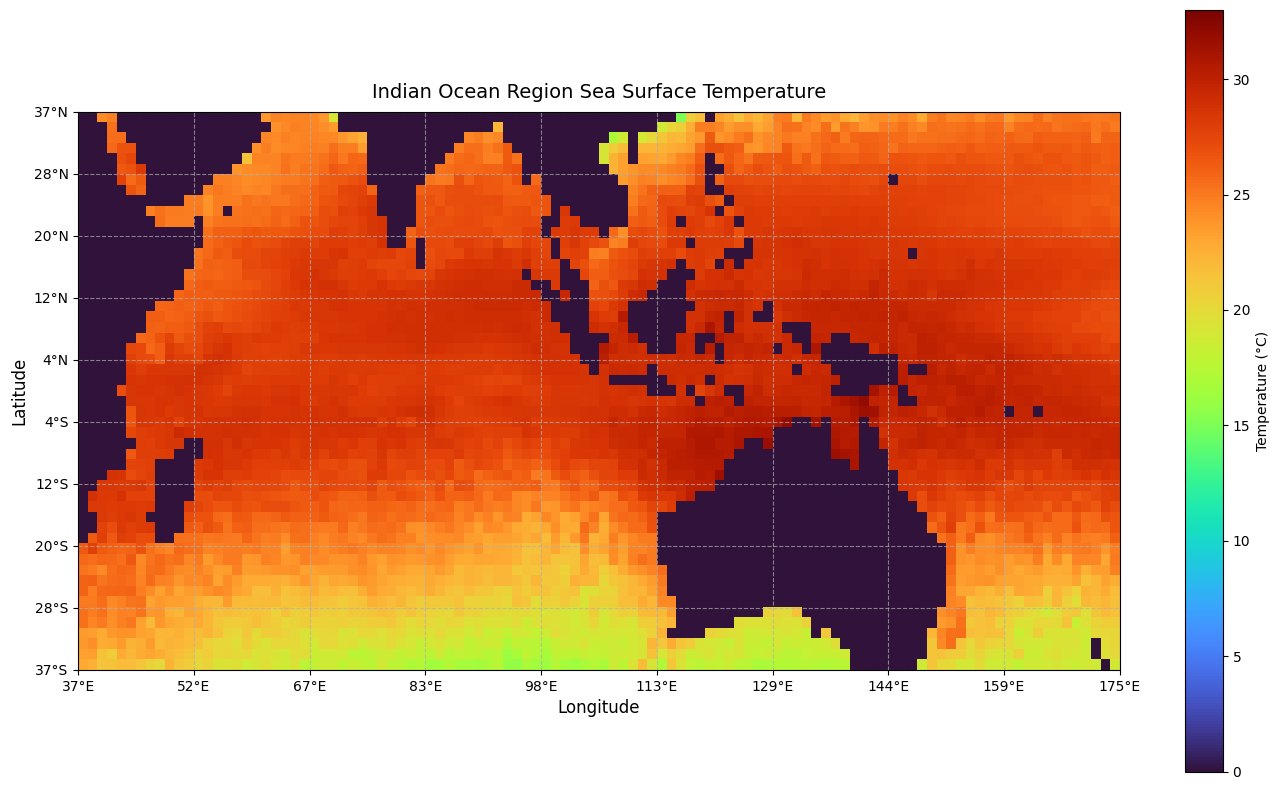

Visualization saved as 'indian_ocean_temperature.png'
Coordinate ranges fixed at longitude: 37°E to 175°E, latitude: 37°S to 37°N


Exception: query error cannot allocate buffer

In [22]:
# Load the dataset
db = load_temperature_dataset()

# Read temperature data for timestep 0
temp_data = read_temperature_data(db, timestep=0, resolution=-15)

# Create a visualization of the full dataset
# visualize_temperature(temp_data)

# Create a visualization focused on the Indian Ocean region
visualize_indian_ocean_region(temp_data)

# To create visualizations for multiple timesteps:
# for ts in range(0, 10, 2):  # Every 2nd timestep from 0 to 8
#     temp_data = read_temperature_data(db, timestep=ts, resolution=-15)
#     visualize_temperature(temp_data, save_path=f'temperature_ts_{ts}.png', 
#                          title=f'Sea Surface Temperature - Timestep {ts}')

for ts in range(0, 10296, 24):  # Every 2nd timestep from 0 to 8
    temp_data = read_temperature_data(db, timestep=ts, resolution=0)
    visualize_indian_ocean_region(temp_data, save_path=f'iod_temperature_ts_{ts}.png', 
                         title=f'Sea Surface Temperature - Timestep {ts}')

In [3]:
def extract_iod_regions(data, western_region=(0.20, 0.30, 0.45, 0.71), eastern_region=(0.32, 0.60, 0.45, 0.71)):
    """
    Extract the Western and Eastern IOD regions from temperature data
    
    Parameters:
    data (np.ndarray): Temperature data array
    western_region (tuple): (x_start_rel, x_end_rel, y_start_rel, y_end_rel) relative positions
    eastern_region (tuple): (x_start_rel, x_end_rel, y_start_rel, y_end_rel) relative positions
    
    Returns:
    tuple: (western_data, eastern_data)
    """
    # Extract Western IOD region (50°E to 70°E and 10°S to 10°N)
    west_x_start = int(data.shape[1] * western_region[0])
    west_x_end = int(data.shape[1] * western_region[1])
    west_y_start = int(data.shape[0] * western_region[2])
    west_y_end = int(data.shape[0] * western_region[3])
    
    western_data = data[west_y_start:west_y_end, west_x_start:west_x_end]
    
    # Extract Eastern IOD region (90°E to 110°E and 10°S to 0°S)
    east_x_start = int(data.shape[1] * eastern_region[0])
    east_x_end = int(data.shape[1] * eastern_region[1])
    east_y_start = int(data.shape[0] * eastern_region[2])
    east_y_end = int(data.shape[0] * eastern_region[3])
    
    eastern_data = data[east_y_start:east_y_end, east_x_start:east_x_end]
    
    return western_data, eastern_data


In [4]:
def calculate_dmi(western_data, eastern_data):
    """
    Calculate the Dipole Mode Index (DMI)
    
    Parameters:
    western_data (np.ndarray): Temperature data for Western IOD region
    eastern_data (np.ndarray): Temperature data for Eastern IOD region
    
    Returns:
    tuple: (western_mean, eastern_mean, dmi)
    """
    # Calculate mean temperatures for each region
    western_mean = np.nanmean(western_data)
    eastern_mean = np.nanmean(eastern_data)
    
    # Calculate DMI (Western mean - Eastern mean)
    dmi = western_mean - eastern_mean
    
    return western_mean, eastern_mean, dmi

prev

In [5]:
def visualize_iod_regions(data, western_region=(0.20, 0.30, 0.45, 0.71), eastern_region=(0.32, 0.60, 0.45, 0.71),
                          vmin=0, vmax=33, cmap='turbo', 
                          title='Indian Ocean Dipole Regions',
                          save_path='iod_regions.png'):
    """
    Visualize the IOD regions and the calculated DMI
    
    Parameters:
    data (np.ndarray): Temperature data array
    western_region (tuple): (x_start_rel, x_end_rel, y_start_rel, y_end_rel) relative positions
    eastern_region (tuple): (x_start_rel, x_end_rel, y_start_rel, y_end_rel) relative positions
    vmin, vmax (float): Min and max values for colormap
    cmap (str): Matplotlib colormap name
    title (str): Plot title
    save_path (str): Path to save the visualization
    """
    # Extract IOD regions
    western_data, eastern_data = extract_iod_regions(data, western_region, eastern_region)
    
    # Calculate DMI
    western_mean, eastern_mean, dmi = calculate_dmi(western_data, eastern_data)
    
    # Create visualization
    plt.figure(figsize=(12, 8))
    
    # Create the plot with temperature colormap
    im = plt.imshow(data, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
    
    # Mark Western IOD region
    west_x_start = int(data.shape[1] * western_region[0])
    west_x_end = int(data.shape[1] * western_region[1])
    west_y_start = int(data.shape[0] * western_region[2])
    west_y_end = int(data.shape[0] * western_region[3])
    
    west_rect = plt.Rectangle((west_x_start, west_y_start), 
                              west_x_end - west_x_start, 
                              west_y_end - west_y_start,
                              linewidth=2, edgecolor='white', facecolor='none')
    plt.gca().add_patch(west_rect)
    plt.text(west_x_start, west_y_start-10, f'Western: {western_mean:.2f}°C', 
             color='white', fontsize=10, weight='bold')
    
    # Mark Eastern IOD region
    east_x_start = int(data.shape[1] * eastern_region[0])
    east_x_end = int(data.shape[1] * eastern_region[1])
    east_y_start = int(data.shape[0] * eastern_region[2])
    east_y_end = int(data.shape[0] * eastern_region[3])
    
    east_rect = plt.Rectangle((east_x_start, east_y_start), 
                              east_x_end - east_x_start, 
                              east_y_end - east_y_start,
                              linewidth=2, edgecolor='black', facecolor='none')
    plt.gca().add_patch(east_rect)
    plt.text(east_x_start, east_y_start-10, f'Eastern: {eastern_mean:.2f}°C', 
             color='black', fontsize=10, weight='bold')
    
    # Add DMI text
    plt.text(west_x_start, data.shape[0]-20, 
             f'DMI: {dmi:.2f}°C {"(Positive)" if dmi > 0 else "(Negative)" if dmi < 0 else "(Neutral)"}', 
             color='black', fontsize=12, weight='bold', 
             bbox=dict(facecolor='white', alpha=0.7))
    
    # Add colorbar
    cbar = plt.colorbar(im, label='Temperature (°C)')
    
    # Add title
    plt.title(title)
    
    # Save the figure
    plt.savefig(save_path, dpi=150)
    plt.show()
    print(f"IOD visualization saved as '{save_path}'")
    
    return western_mean, eastern_mean, dmi

new

In [10]:
def visualize_iod_regions(data, western_region=(0.20, 0.30, 0.45, 0.71), eastern_region=(0.32, 0.60, 0.45, 0.71),
                          vmin=0, vmax=33, cmap='turbo', 
                          title='Indian Ocean Dipole Regions',
                          save_path='iod_regions.png'):
    """
    Visualize the IOD regions and the calculated DMI with longitude and latitude on axes
    
    Parameters:
    data (np.ndarray): Temperature data array
    western_region (tuple): (x_start_rel, x_end_rel, y_start_rel, y_end_rel) relative positions
    eastern_region (tuple): (x_start_rel, x_end_rel, y_start_rel, y_end_rel) relative positions
    vmin, vmax (float): Min and max values for colormap
    cmap (str): Matplotlib colormap name
    title (str): Plot title
    save_path (str): Path to save the visualization
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.ticker import FuncFormatter
    
    # Helper function to convert array indices to longitude
    def x_to_lon(x):
        if x < 800:
            return -38 + (x/21)
        else:
            return (x-800)/21
    
    # Helper function to convert array indices to latitude
    def y_to_lat(y):
        return (y - 3750) / 40.7
    
    # Define the extraction function here if not already defined
    def extract_iod_regions(data, western_region, eastern_region):
        # Extract Western IOD region
        west_x_start = int(data.shape[1] * western_region[0])
        west_x_end = int(data.shape[1] * western_region[1])
        west_y_start = int(data.shape[0] * western_region[2])
        west_y_end = int(data.shape[0] * western_region[3])
        
        western_data = data[west_y_start:west_y_end, west_x_start:west_x_end]
        
        # Extract Eastern IOD region
        east_x_start = int(data.shape[1] * eastern_region[0])
        east_x_end = int(data.shape[1] * eastern_region[1])
        east_y_start = int(data.shape[0] * eastern_region[2])
        east_y_end = int(data.shape[0] * eastern_region[3])
        
        eastern_data = data[east_y_start:east_y_end, east_x_start:east_x_end]
        
        return western_data, eastern_data
    
    # Define the DMI calculation function here if not already defined
    def calculate_dmi(western_data, eastern_data):
        western_mean = np.nanmean(western_data)
        eastern_mean = np.nanmean(eastern_data)
        dmi = western_mean - eastern_mean
        return western_mean, eastern_mean, dmi
    
    # Extract IOD regions
    western_data, eastern_data = extract_iod_regions(data, western_region, eastern_region)
    
    # Calculate DMI
    western_mean, eastern_mean, dmi = calculate_dmi(western_data, eastern_data)
    
    # Create visualization
    plt.figure(figsize=(14, 10))
    
    # Create the plot with temperature colormap
    im = plt.imshow(data, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
    
    # Mark Western IOD region
    west_x_start = int(data.shape[1] * western_region[0])
    west_x_end = int(data.shape[1] * western_region[1])
    west_y_start = int(data.shape[0] * western_region[2])
    west_y_end = int(data.shape[0] * western_region[3])
    
    # Calculate the actual longitude and latitude ranges for the western region
    west_lon_start = x_to_lon(west_x_start)
    west_lon_end = x_to_lon(west_x_end)
    west_lat_start = y_to_lat(west_y_start)
    west_lat_end = y_to_lat(west_y_end)
    
    west_rect = plt.Rectangle((west_x_start, west_y_start), 
                              west_x_end - west_x_start, 
                              west_y_end - west_y_start,
                              linewidth=2, edgecolor='white', facecolor='none')
    plt.gca().add_patch(west_rect)
    
    # Mark Eastern IOD region
    east_x_start = int(data.shape[1] * eastern_region[0])
    east_x_end = int(data.shape[1] * eastern_region[1])
    east_y_start = int(data.shape[0] * eastern_region[2])
    east_y_end = int(data.shape[0] * eastern_region[3])
    
    # Calculate the actual longitude and latitude ranges for the eastern region
    east_lon_start = x_to_lon(east_x_start)
    east_lon_end = x_to_lon(east_x_end)
    east_lat_start = y_to_lat(east_y_start)
    east_lat_end = y_to_lat(east_y_end)
    
    east_rect = plt.Rectangle((east_x_start, east_y_start), 
                              east_x_end - east_x_start, 
                              east_y_end - east_y_start,
                              linewidth=2, edgecolor='black', facecolor='none')
    plt.gca().add_patch(east_rect)
    
    # Position text labels to avoid overlap
    plt.text(west_x_start, west_y_start-20, f'Western: {western_mean:.2f}°C', 
             color='white', fontsize=10, weight='bold',
             bbox=dict(facecolor='black', alpha=0.6, boxstyle='round,pad=0.5'))
    
    plt.text(east_x_start, east_y_end+10, f'Eastern: {eastern_mean:.2f}°C', 
             color='black', fontsize=10, weight='bold',
             bbox=dict(facecolor='white', alpha=0.6, boxstyle='round,pad=0.5'))
    
    # Add DMI text at a better position
    plt.text(int(data.shape[1] * 0.05), int(data.shape[0] * 0.95), 
             f'DMI: {dmi:.2f}°C {"(Positive)" if dmi > 0 else "(Negative)" if dmi < 0 else "(Neutral)"}', 
             color='white', fontsize=12, weight='bold', 
             bbox=dict(facecolor='black', alpha=0.7, boxstyle='round,pad=0.5'))
    
    # Add colorbar
    cbar = plt.colorbar(im, label='Temperature (°C)')
    
    # Add title
    plt.title(title, fontsize=14, pad=20)
    
    # Set custom axis formatters to display longitude/latitude
    def lon_formatter(x, pos):
        lon = x_to_lon(x)
        return f'{lon:.0f}°E' if lon >= 0 else f'{abs(lon):.0f}°W'
    
    def lat_formatter(y, pos):
        lat = y_to_lat(y)
        return f'{lat:.0f}°N' if lat >= 0 else f'{abs(lat):.0f}°S'
    
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lon_formatter))
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lat_formatter))
    
    # Set x and y labels
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    
    # Print the actual longitude and latitude ranges for the regions (for verification)
    print(f"Western region: Longitude {west_lon_start:.1f}°E to {west_lon_end:.1f}°E, Latitude {west_lat_start:.1f}°N to {west_lat_end:.1f}°N")
    print(f"Eastern region: Longitude {east_lon_start:.1f}°E to {east_lon_end:.1f}°E, Latitude {east_lat_start:.1f}°N to {east_lat_end:.1f}°N")
    
    # Save the figure
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()
    print(f"IOD visualization saved as '{save_path}'")
    
    return western_mean, eastern_mean, dmi

In [6]:
def analyze_iod_timeseries(db, start_timestep=0, end_timestep=10296, step=24, resolution=-15,
                          western_region=(0.20, 0.30, 0.45, 0.71), eastern_region=(0.32, 0.60, 0.45, 0.71)):
    """
    Analyze IOD over a time series and create a DMI plot
    
    Parameters:
    db (ov.Dataset): OpenVisus dataset object
    start_timestep (int): Starting timestep
    end_timestep (int): Ending timestep
    step (int): Step size between timesteps
    resolution (int): Resolution level (-15 to 0)
    western_region (tuple): (x_start_rel, x_end_rel, y_start_rel, y_end_rel) relative positions
    eastern_region (tuple): (x_start_rel, x_end_rel, y_start_rel, y_end_rel) relative positions
    
    Returns:
    DataFrame: Time series data with DMI values
    """
    timesteps = list(range(start_timestep, end_timestep + 1, step))
    
    # Initialize results
    results = {
        'timestep': [],
        'western_temp': [],
        'eastern_temp': [],
        'dmi': [],
        'phase': []
    }
    
    # Process each timestep
    for ts in tqdm(timesteps, desc="Analyzing IOD time series"):
        # Read temperature data
        temp_data = read_temperature_data(db, timestep=ts, resolution=resolution)
        
        # Extract IOD regions
        western_data, eastern_data = extract_iod_regions(temp_data, western_region, eastern_region)
        
        # Calculate DMI
        western_mean, eastern_mean, dmi = calculate_dmi(western_data, eastern_data)
        
        # Determine IOD phase
        if dmi > 0.5:
            phase = 'Positive'
        elif dmi < -0.5:
            phase = 'Negative'
        else:
            phase = 'Neutral'
        
        # Store results
        results['timestep'].append(ts)
        results['western_temp'].append(western_mean)
        results['eastern_temp'].append(eastern_mean)
        results['dmi'].append(dmi)
        results['phase'].append(phase)
        
        # Optional: Create visualization for this timestep
        # visualize_iod_regions(temp_data, western_region, eastern_region,
        #                      save_path=f'iod_regions_ts_{ts}.png',
        #                      title=f'IOD Analysis - Timestep {ts}')
    
    # Create DataFrame
    df = pd.DataFrame(results)
    
    # Plot DMI time series
    plt.figure(figsize=(14, 8))
    
    # Plot Western and Eastern temperatures
    plt.subplot(2, 1, 1)
    plt.plot(df['timestep'], df['western_temp'], 'r-', label='Western Indian Ocean')
    plt.plot(df['timestep'], df['eastern_temp'], 'b-', label='Eastern Indian Ocean')
    plt.xlabel('Timestep')
    plt.ylabel('Temperature (°C)')
    plt.title('Indian Ocean Region Temperatures')
    plt.legend()
    plt.grid(True)
    
    # Plot DMI
    plt.subplot(2, 1, 2)
    plt.plot(df['timestep'], df['dmi'], 'g-')
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.3, label='Positive Threshold')
    plt.axhline(y=-0.5, color='b', linestyle='--', alpha=0.3, label='Negative Threshold')
    
    plt.fill_between(df['timestep'], df['dmi'], 0, 
                    where=(df['dmi'] > 0), 
                    color='red', alpha=0.3, label='Positive IOD')
    plt.fill_between(df['timestep'], df['dmi'], 0, 
                    where=(df['dmi'] < 0), 
                    color='blue', alpha=0.3, label='Negative IOD')
    
    plt.xlabel('Timestep')
    plt.ylabel('DMI (°C)')
    plt.title('Dipole Mode Index (DMI)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('dmi_timeseries.png', dpi=150)
    plt.show()
    print("DMI time series analysis saved as 'dmi_timeseries.png'")
    
    # Save results to CSV
    df.to_csv('iod_analysis_results.csv', index=False)
    print("Results saved to 'iod_analysis_results.csv'")
    
    return df

Dimensions: 8640*6480*90
Total Timesteps: 10366
Field: theta
Data Type: float32
Data shape: (3, 203, 270)
Data min: -2.0670995712280273, max: 32.04000473022461
Western region: Longitude -35.4°E to -34.1°E, Latitude -89.9°N to -88.6°N
Eastern region: Longitude -33.9°E to -30.3°E, Latitude -89.9°N to -88.6°N


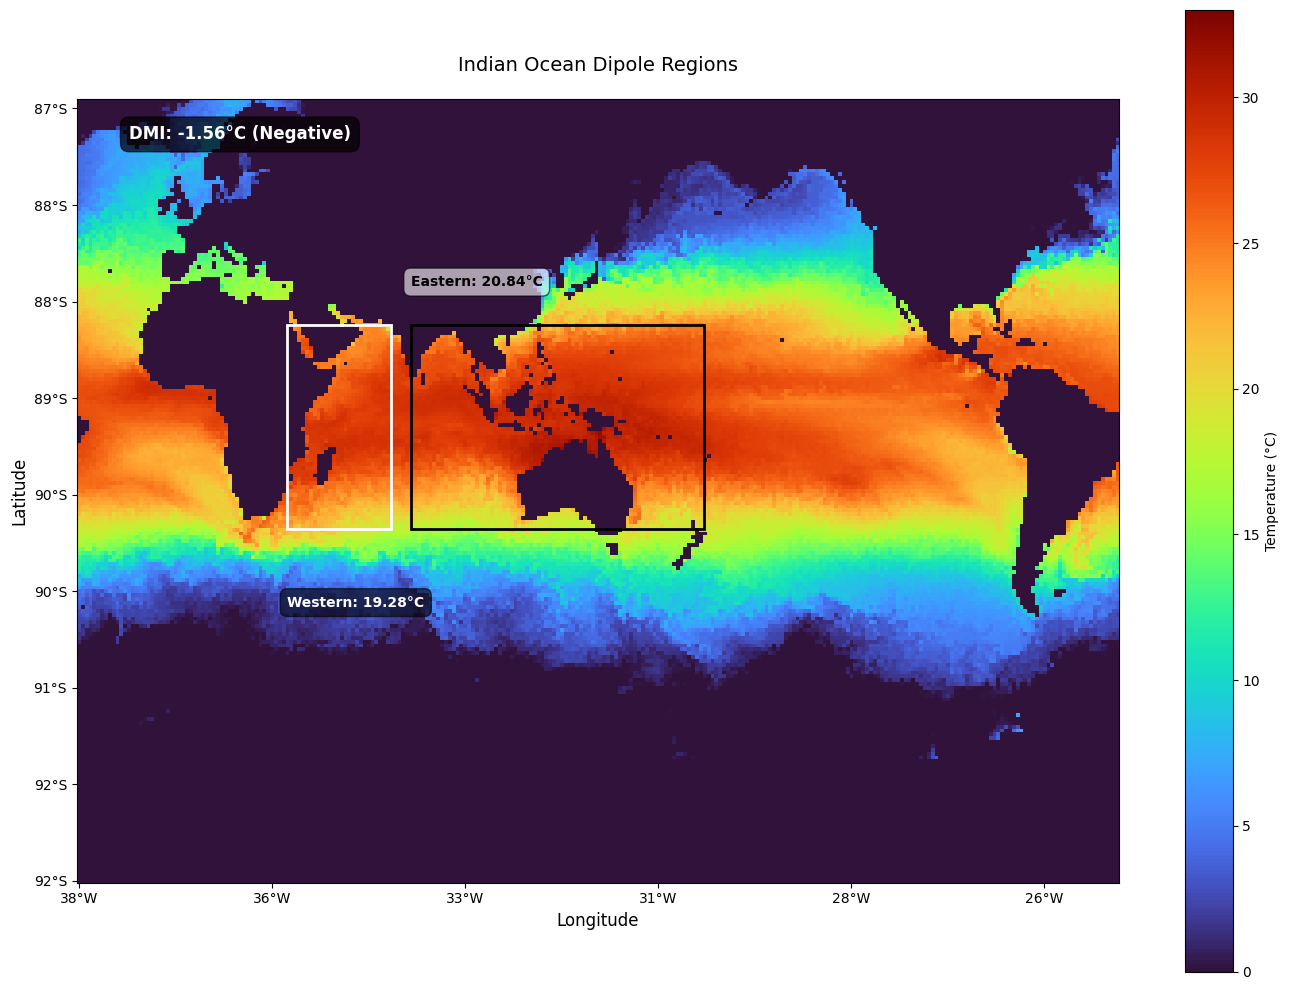

IOD visualization saved as 'iod_regions.png'
Western region mean temperature: 19.28°C
Eastern region mean temperature: 20.84°C
Dipole Mode Index (DMI): -1.56°C
IOD Phase: Negative


Analyzing IOD time series:   0%|          | 0/62 [00:00<?, ?it/s]

Data shape: (3, 203, 270)
Data min: -2.0670995712280273, max: 32.04000473022461
Data shape: (3, 203, 270)
Data min: -1.9046705961227417, max: 32.648475646972656
Data shape: (3, 203, 270)
Data min: -1.889367938041687, max: 33.993988037109375
Data shape: (3, 203, 270)
Data min: -1.8900399208068848, max: 33.818878173828125
Data shape: (3, 203, 270)
Data min: -1.8896033763885498, max: 32.882816314697266
Data shape: (3, 203, 270)
Data min: -1.889315128326416, max: 33.297019958496094
Data shape: (3, 203, 270)
Data min: -1.8892759084701538, max: 33.3990478515625
Data shape: (3, 203, 270)
Data min: -1.8887816667556763, max: 33.8034553527832
Data shape: (3, 203, 270)
Data min: -1.8889524936676025, max: 33.40976333618164
Data shape: (3, 203, 270)
Data min: -1.8882538080215454, max: 33.55422592163086
Data shape: (3, 203, 270)
Data min: -1.874760389328003, max: 33.4390983581543
Data shape: (3, 203, 270)
Data min: -1.8708831071853638, max: 33.860660552978516
Data shape: (3, 203, 270)
Data min: -1.8

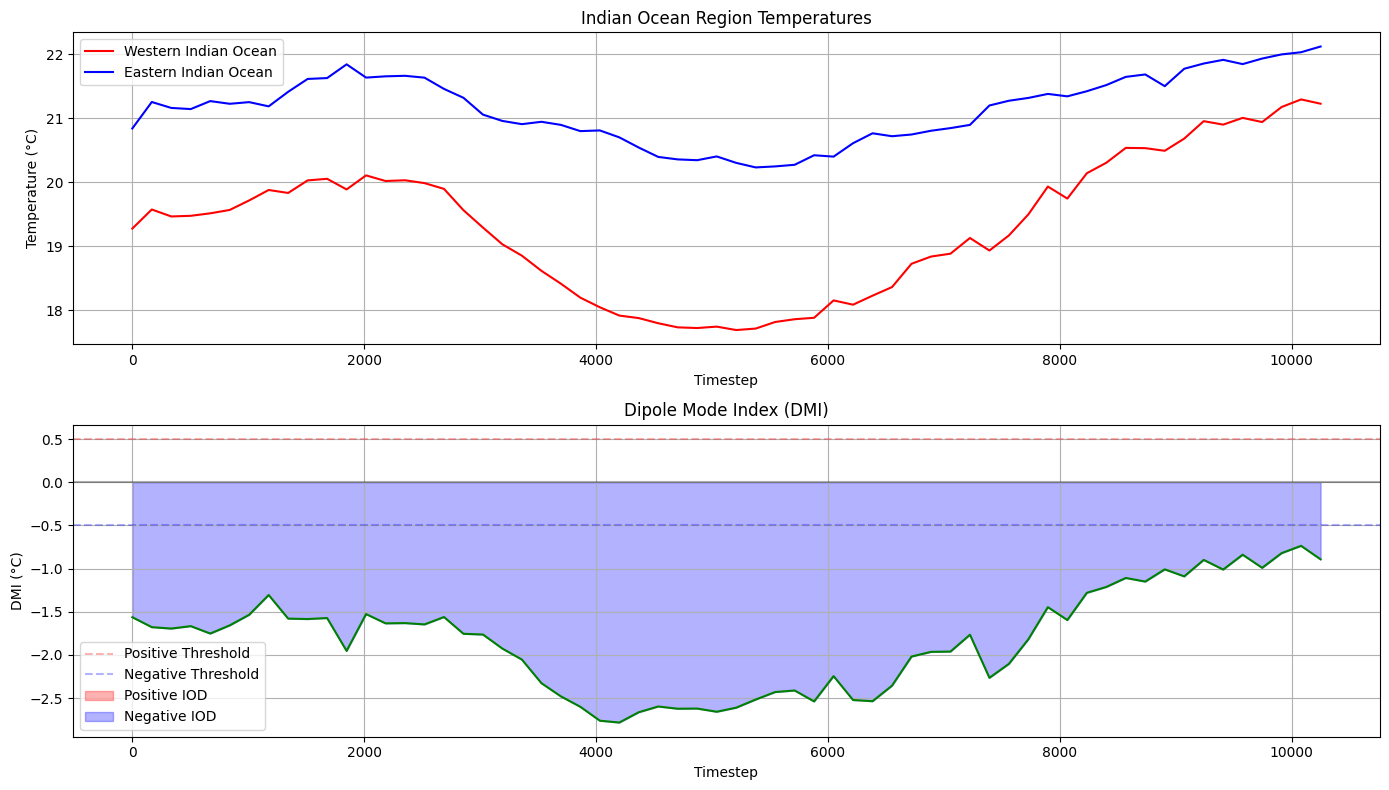

DMI time series analysis saved as 'dmi_timeseries.png'
Results saved to 'iod_analysis_results.csv'


In [11]:

# Load the dataset
db = load_temperature_dataset()

# Read temperature data for timestep 0
temp_data = read_temperature_data(db, timestep=0, resolution=-15)

# Visualize IOD regions and calculate DMI for a single timestep
western_mean, eastern_mean, dmi = visualize_iod_regions(temp_data)
print(f"Western region mean temperature: {western_mean:.2f}°C")
print(f"Eastern region mean temperature: {eastern_mean:.2f}°C")
print(f"Dipole Mode Index (DMI): {dmi:.2f}°C")
print(f"IOD Phase: {'Positive' if dmi > 0.5 else 'Negative' if dmi < -0.5 else 'Neutral'}")

# For time series analysis:
dmi_df = analyze_iod_timeseries(db, start_timestep=0, end_timestep=10296, step=24*7)  # Weekly analysis
